<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 삼성전자 주가를 예측하여 보자

In [0]:
## 라이브러리 불러오기
import pandas as pd; import numpy as np;import matplotlib.pyplot as plt
from keras.models import Sequential; from keras.layers import LSTM, Dropout, Dense, Activation;import datetime


In [0]:
!git clone https://github.com/hongjai-rhee/public.git
## 깃허브 디렉토리 마운트
dat = pd.read_csv('/content/public/stock.csv)
print(dat.head(10))  

fatal: destination path 'public' already exists and is not an empty directory.
         Date   Open   High    Low  Close  Adj Close    Volume
0  2013-10-30  29700  30000  29680  30000  41.274914  10588400
1  2013-10-31  29960  30040  29300  29300  40.311840  12647050
2  2013-11-01  29800  30000  29360  30000  41.274914  11357700
3  2013-11-04  29840  30040  29780  29980  41.247398  10887800
4  2013-11-05  30040  30040  29440  29700  40.862167   8009300
5  2013-11-06  29960  29960  28980  29020  39.926601  12218400
6  2013-11-07  29020  29080  28500  28740  39.541370  13006800
7  2013-11-08  28220  28560  28140  28200  38.798420  13681350
8  2013-11-11  28500  28680  28180  28560  39.293724   8563850
9  2013-11-12  28800  29320  28720  29120  40.064182   9784900


In [0]:
dat.shape

(1225, 7)

# 분석대상 가격과 윈도우 결정
종가를 기준으로 분석하려고 한다. 
최근 50일간(window)의 주가가 다음 날짜의 주가에 영향을 준다고 가정하자. 

 


In [0]:
high_prices = data['High'].values
low_prices = data['Low'].values
prices = data['Close'].values


seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(prices) - sequence_length):
    result.append(prices[index: index + sequence_length])

일반적으로 데이터를 정규화해서 사용한다.  

In [0]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

# 모형 설정
Time Series에 특화된 LSTM 모델을 사용한다.



In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# 학습하기

In [0]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=5)

Train on 1057 samples, validate on 117 samples
Epoch 1/5
1057/1057 [==============================] - 9s 8ms/step - loss: 3.2336e-04 - val_loss: 3.4138e-04
Epoch 2/5
1057/1057 [==============================] - 9s 8ms/step - loss: 3.2250e-04 - val_loss: 2.4616e-04
Epoch 3/5
1057/1057 [==============================] - 9s 8ms/step - loss: 3.2505e-04 - val_loss: 2.8252e-04
Epoch 4/5
1057/1057 [==============================] - 9s 8ms/step - loss: 3.1708e-04 - val_loss: 4.1479e-04
Epoch 5/5
1057/1057 [==============================] - 8s 8ms/step - loss: 3.1644e-04 - val_loss: 2.5719e-04


# 예측과 실제 데이터 비교

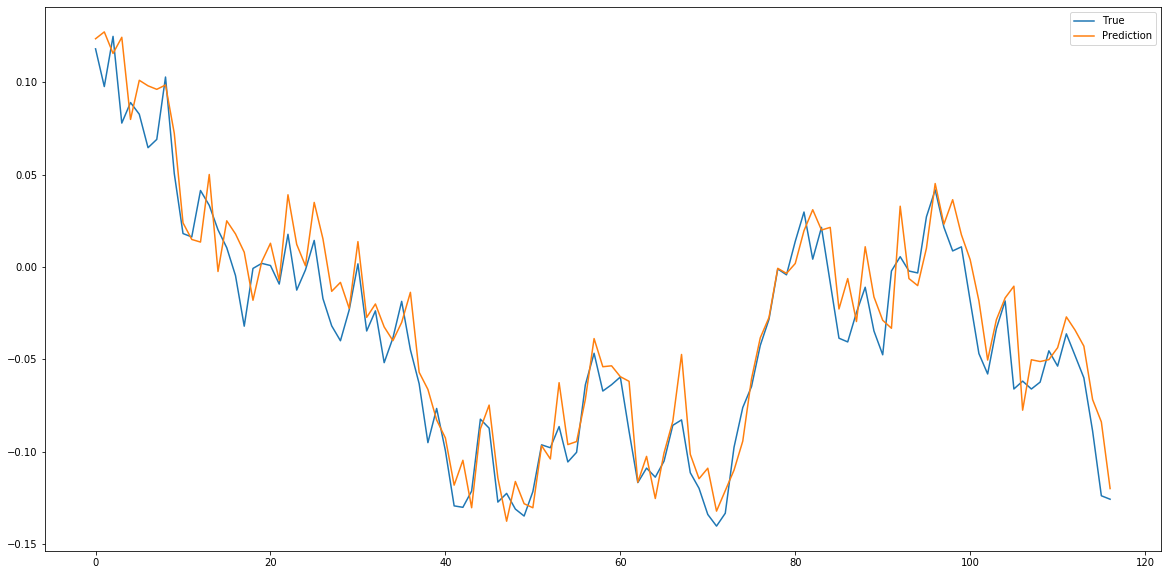

In [0]:

pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Attention!
실제로 맞지 않는 경우가 많습니다. shock이나 내부정보는 알지 못합니다. 이 모델을 사용한 투자결과에 1도 책임지지 않습니다.
